In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import os
import matplotlib.pyplot as plt
import numpy as np
 
!pip install kaggle

In [ ]:
path='/root/.kaggle/'
file='kaggle.json'
if not (os.path.exists(path)):
  os.mkdir(path)
if not (os.path.exists('/root/.kaggle/kaggle.json')):
  with open(os.path.join(path, file), 'w+') as fp:
    print(fp) 
  !echo '{"username":"shakashan","key":"fd87c0dbed808b92ff1df5897b8bfa48"}' > /root/.kaggle/kaggle.json
  ! chmod 600 ~/.kaggle/kaggle.json
 
! kaggle datasets download -d vipoooool/new-plant-diseases-dataset
 
!unzip /content/new-plant-diseases-dataset.zip
 

Streaming output truncated to the last 5000 lines.
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/273a7a9e-18be-4b6a-976a-fa5ffd69b731___RS_HL 4366_90deg.JPG  
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/275f8963-f4f4-4903-962b-1da716725d08___RS_HL 4780_90deg.JPG  
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/275f8963-f4f4-4903-962b-1da716725d08___RS_HL 4780_new30degFlipLR.JPG  
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/27c2aaa4-de4b-4fb1-ba8d-14d4b24b2afa___RS_HL 4665.JPG  
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/27c2aaa4-de4b-4fb1-ba8d-14d4b24b2afa___RS_HL 4665_270deg.JPG  
  inflating: new plant diseases dataset(augmented)/New 

In [ ]:

data_dir='new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/train'
test_dir='new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid'
batch_size=128
target_size=(224,224)
epoch=100
 

In [ ]:

from keras.preprocessing.image import ImageDataGenerator
data_train_generator=ImageDataGenerator(rescale=1./255,zoom_range=0.2,
                                        width_shift_range=0.2,
                                        height_shift_range=0.2,
                                        shear_range=0.2,
                                        fill_mode='nearest')
data_valid_generator = ImageDataGenerator(rescale=1./255)
data_train=data_train_generator.flow_from_directory(directory=data_dir,
                                              shuffle=True,
                                              target_size=target_size,
                                              batch_size=batch_size)
data_test=data_valid_generator.flow_from_directory(directory=test_dir,
                                              shuffle=True,
                                              target_size=target_size,
                                              batch_size=batch_size)
 
len_data=data_train.n+data_test.n
percentage_train_data= int((data_train.n/len_data)*100)
print(str(percentage_train_data) + ' %')

Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.
80 %


In [ ]:
IMG_SHAPE = target_size + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
 
class_names=data_train.class_indices
 
image_batch, label_batch = next(iter(data_train))
feature_batch = base_model(image_batch)
print(feature_batch.shape)
 

9412608/9406464 [==============================] - 0s 0us/step
(128, 7, 7, 1280)


In [ ]:
model=tf.keras.Sequential([  
                           tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet'),
                           tf.keras.layers.MaxPooling2D(2,2,padding='same'),
                           tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
                           tf.keras.layers.BatchNormalization(),
                           tf.keras.layers.MaxPooling2D(2,2,padding='same'),
                           tf.keras.layers.Flatten(),
                           tf.keras.layers.Dense(128,activation='relu'),
                           tf.keras.layers.Dropout(0.2),
                           tf.keras.layers.BatchNormalization(),
                           tf.keras.layers.Dense(64,activation='relu'),
                           tf.keras.layers.Dropout(0.2),
                           tf.keras.layers.BatchNormalization(),
                           tf.keras.layers.Dense(38,activation='softmax')
                           ])
model.layers[0].trainable=False
 
model.compile(
            optimizer=tf.keras.optimizers.Adam(),
            loss='categorical_crossentropy',
            metrics=['acc'])

In [7]:
path_checkpoint = "model_checkpoint.h5"
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('acc')>0.93 and  logs.get('val_acc')>0.93):
      print("\nAkurasi telah mencapai >92%!")
      self.model.stop_training = True
modelckpt_callback = tf.keras.callbacks.ModelCheckpoint(
    monitor="loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)
 
history = model.fit(
    data_train,
    epochs=epoch,
    validation_data=data_test,
    callbacks=[myCallback(), modelckpt_callback],
)

Epoch 1/100
550/550 [==============================] - 789s 1s/step - loss: 1.7878 - acc: 0.5327 - val_loss: 0.3300 - val_acc: 0.8988

Epoch 00001: loss improved from inf to 1.06473, saving model to model_checkpoint.h5
Epoch 2/100
550/550 [==============================] - 796s 1s/step - loss: 0.4427 - acc: 0.8658 - val_loss: 0.2768 - val_acc: 0.9129

Epoch 00002: loss improved from 1.06473 to 0.41422, saving model to model_checkpoint.h5
Epoch 3/100
550/550 [==============================] - 795s 1s/step - loss: 0.3339 - acc: 0.8965 - val_loss: 0.2446 - val_acc: 0.9206

Epoch 00003: loss improved from 0.41422 to 0.33207, saving model to model_checkpoint.h5
Epoch 4/100
550/550 [==============================] - 789s 1s/step - loss: 0.2936 - acc: 0.9092 - val_loss: 0.2832 - val_acc: 0.9079

Epoch 00004: loss improved from 0.33207 to 0.28855, saving model to model_checkpoint.h5
Epoch 5/100
550/550 [==============================] - 788s 1s/step - loss: 0.2706 - acc: 0.9130 - val_loss: 0.2

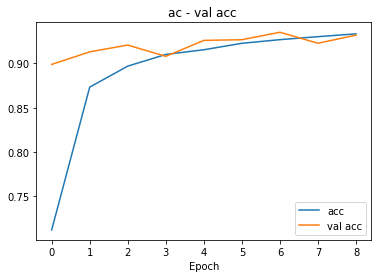

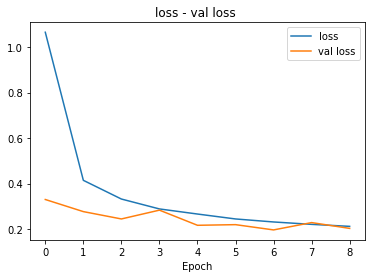

In [8]:
import matplotlib.pyplot as plt
 
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('ac - val acc ')
plt.xlabel('Epoch')
plt.legend(['acc','val acc'], loc='best')
plt.show()
 
import matplotlib.pyplot as plt
 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss - val loss ')
plt.xlabel('Epoch')
plt.legend(['loss','val loss'], loc='best')
plt.show()

In [9]:
def getList(dict):
    list = []
    for key in dict.keys():
        list.append(key)
          
    return list
 
pesticides=["Bonide® Orchard","fireblight", "Immunox", "None", "None",
         "Potassium bicarbonate", "None",
         "Fungicides", "Numerous fungicides",
         "fungicide Dithane M-45", "None", "Mancozeb",
         "carbaryl", "captan", "None",
         "No Cure", "chlorothalonil", "None", "Clorox® bleach",
         "None", "Bayer Garden Blight Control", "mancozeb", "None", "None",
         "None", " Potassium bicarbonate", "fungicides", "None", "Burn it",
         "Bonide Liquid Copper Fungicide concentrate", "mancozeb", "chlorothalonil", "copper",
         "pyrethrins", "septoria leaf spot", "Capture",
         "No Cure", "None"]
li = list(class_names.keys())
print(li)

Saving CornCommonRust1.JPG to CornCommonRust1 (1).JPG


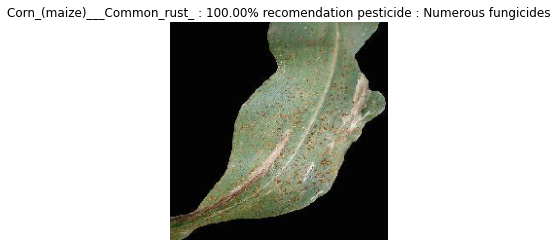

In [16]:
from google.colab import files 
uploaded = files.upload()
image_name=(getList(uploaded))[0]
b = image.load_img(image_name, target_size=(224, 224))
a = image.img_to_array(b)
a = np.expand_dims(a, axis=0)
a = a/255
out=model.predict(a)
percentage=np.max(out)*100

li[np.argmax(out)]
 
plt.figure(figsize = (4,4))
plt.imshow(b)
plt.axis('off')
plt.title(li[np.argmax(out)]+" : "+"{:.2f}".format(percentage) +'% recomendation pesticide : '+pesticides[np.argmax(out)])
plt.show()

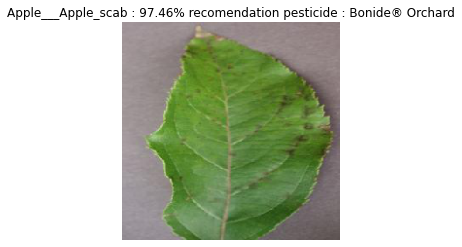

In [11]:
 
b = image.load_img('/content/test/test/AppleScab1.JPG', target_size=(224, 224))
a = image.img_to_array(b)
a = np.expand_dims(a, axis=0)
a = a/255
out=model.predict(a)
percentage=np.max(out)*100
li[np.argmax(out)]
 
plt.figure(figsize = (4,4))
plt.imshow(b)
plt.axis('off')
plt.title(li[np.argmax(out)]+" : "+"{:.2f}".format(percentage) +'% recomendation pesticide : '+pesticides[np.argmax(out)])
plt.show()